<a href="https://colab.research.google.com/github/johannanguyen/nfl_stats/blob/master/nfl_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from io import StringIO
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
import numpy as np
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from scipy import stats

In [2]:
def import_table(category, year):
  url = f"https://www.nfl.com/stats/player-stats/category/{category}/{year}/reg/all/{category}yards/desc"
  response = requests.get(url)
  soup = BeautifulSoup(response.text, "html.parser")

  table = soup.find("table")
  results = pd.read_html(StringIO(str(table)))[0]

  return results

# Quarterbacks

---

## Do efficient passers have better ratings? Yes

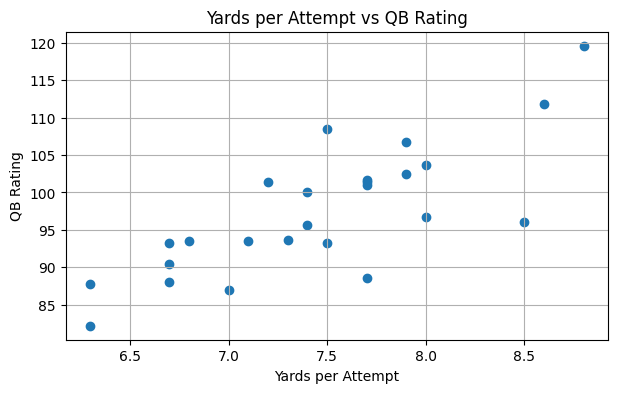

## Using the Pearson Correlation Coefficient

Pearson Correlation Coefficient: 0.7822212120035172 ✅
P value: 3.853214337575798e-06 ✅



<b>Conclusion:</b> There is a significant positive correlation between yards per attempt and QB rating.

In [3]:
display(Markdown("# Quarterbacks"))
display(Markdown("---"))

qb_2024 = import_table("passing", "2024")

# Yards per Attempt vs QB Rating Graph
display(Markdown("## Do efficient passers have better ratings? Yes"))
x = qb_2024['Yds/Att']
y = qb_2024['Rate']

plt.figure(figsize=(7, 4))
plt.scatter(x, y)

plt.xlabel("Yards per Attempt")
plt.ylabel("QB Rating")
plt.title("Yards per Attempt vs QB Rating")
plt.grid(True)
plt.show()


# Statistical Evidence
# Pearson Correlation Coefficient ranges between [-1, 1]; measures strength/direction of relationship
# p value tests statistical significance; < 0.05 unlikely to be coincidental
display(Markdown("## Using the Pearson Correlation Coefficient"))
pcc, p_val =  pearsonr(qb_2024['Yds/Att'], qb_2024['Rate'])
print(f"Pearson Correlation Coefficient: {pcc} ✅")
print(f"P value: {p_val} ✅\n")
display(Markdown("<b>Conclusion:</b> There is a significant positive correlation between yards per attempt and QB rating."))

# Quarterbacks

---

## Do high-volume QBs score more TDs?

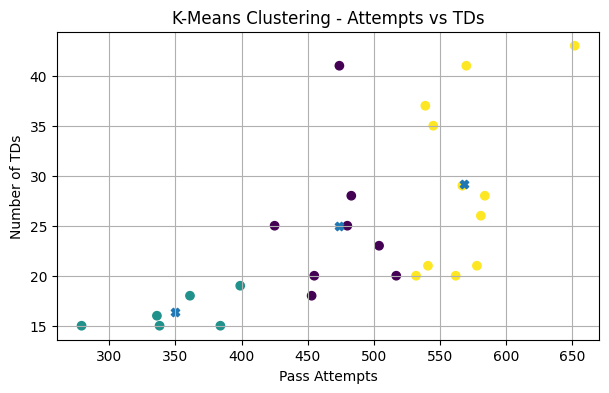

## Using the T-test

T-statistic: 2.207793806091292
p-value: 0.037503667873498514


<b>Conclusion:</b> There is a significant positive correlation between high-volume QBs and number of TDs scored.

In [4]:
display(Markdown("# Quarterbacks"))
display(Markdown("---"))

# Yards per Attempt vs QB Rating Graph
# Include KMeans clustering
display(Markdown("## Do high-volume QBs score more TDs?"))
x = qb_2024['Att']
y = qb_2024['TD']

# Combine both columns into a 2D array for KMeans()
X = np.column_stack((x, y))

# Use 3 clusters, pick 3 centroids, assign each point to a centroid
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
plt.figure(figsize=(7, 4))

# Use label to color each point
scatter = plt.scatter(x, y, c=labels)
plt.scatter(centroids[:, 0], centroids[:, 1], marker="X")

plt.xlabel("Pass Attempts")
plt.ylabel("Number of TDs")
plt.title("K-Means Clustering - Attempts vs TDs")
plt.grid(True)
plt.show()

# T-test
# The further from 0 the T-statistic, the larger the difference
# p value tests statistical significance; < 0.05 unlikely to be coincidental
display(Markdown("## Using the T-test"))
median_att = qb_2024['Att'].median()
high_volume = qb_2024[qb_2024['Att'] > median_att]['TD']
low_volume = qb_2024[qb_2024['Att'] <= median_att]['TD']
t_stat, p_val = ttest_ind(high_volume, low_volume)

print(f"T-statistic: {t_stat:}\np-value: {p_val}")
display(Markdown("<b>Conclusion:</b> There is a significant positive correlation between high-volume QBs and number of TDs scored."))

# Quarterbacks

---

## What is the trade-off between aggressive scoring and turnovers?

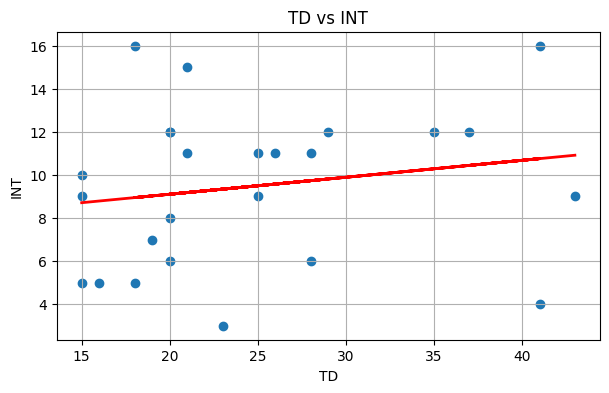

## Linear Regression

Slope: 0.07870517296096477
Intercept: 7.531259917486513


<b>Conclusion:</b> There is a positive correlation between aggressive scoring and turnovers; however, it is minimal.

In [5]:
display(Markdown("# Quarterbacks"))
display(Markdown("---"))

# TD vs INT Graph
display(Markdown("## What is the trade-off between aggressive scoring and turnovers?"))
x = qb_2024['TD']
y = qb_2024['INT']

plt.figure(figsize=(7, 4))
plt.scatter(x, y)
plt.xlabel("TD")
plt.ylabel("INT")
plt.title("TD vs INT")
plt.grid(True)

# Linear Regression
x = qb_2024[['TD']].values
y = qb_2024['INT'].values
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red', linewidth=2, label='Regression line')  # Regression line
plt.show()

# If slope is positive, more risk = more reward
# Intercept is the expected number of INTs when a QB throws 0 TDs
display(Markdown("## Linear Regression"))
print(f"Slope: {model.coef_[0]}")
print(f"Intercept: {model.intercept_}")
display(Markdown("<b>Conclusion:</b> There is a positive correlation between aggressive scoring and turnovers; however, it is minimal."))

# Running Backs

---

## Do top running backs get most of their yards from short runs or do long runs make a big difference?

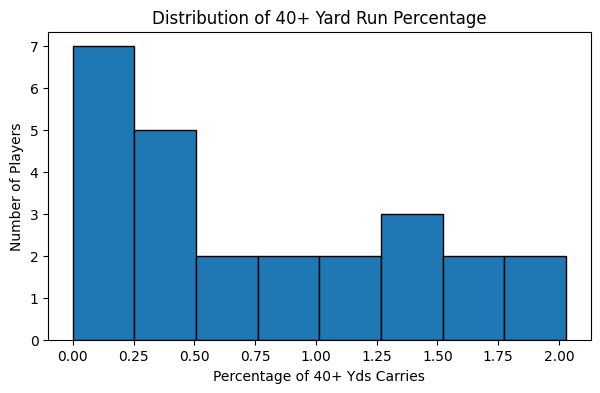

## One Sample T-test

T-statistic: -17.092433393356306 
P-value: 6.121933246658784e-15



<b>Conclusion:</b> The average 40+% yards is 17 standard deviations less than the tested 3%.

Running backs rely on consistent short runs far more than rare explosive breakaway runs.

In [13]:
display(Markdown("# Running Backs"))
display(Markdown("---"))

# Percentage of 40+ out of all attempts graph
display(Markdown("## Do top running backs get most of their yards from short runs or do long runs make a big difference?"))

rushing_2024 = import_table("rushing", "2024")

rushing_2024["40+%"] = (rushing_2024["40+"] / rushing_2024["Att"]) * 100
plt.figure(figsize=(7, 4))
plt.hist(rushing_2024["40+%"], bins=8, edgecolor='black')
plt.title("Distribution of 40+ Yard Run Percentage")
plt.xlabel("Percentage of 40+ Yds Carries")
plt.ylabel("Number of Players")
plt.show()

display(Markdown("## One Sample T-test"))
# Check if average 40+ yard run rate is < 3%
test_value = 3.0
t_stat, p_value = stats.ttest_1samp(rushing_2024['40+%'], test_value)
print(f"T-statistic: {t_stat} ")
print(f"P-value: {p_value:}\n")

display(Markdown("<b>Conclusion:</b> The average 40+% yards is 17 standard deviations less than the tested 3%."))
display(Markdown("Running backs rely on consistent short runs far more than rare explosive breakaway runs."))

# Running Backs

---

## How efficient are running backs on a per-carry basis?

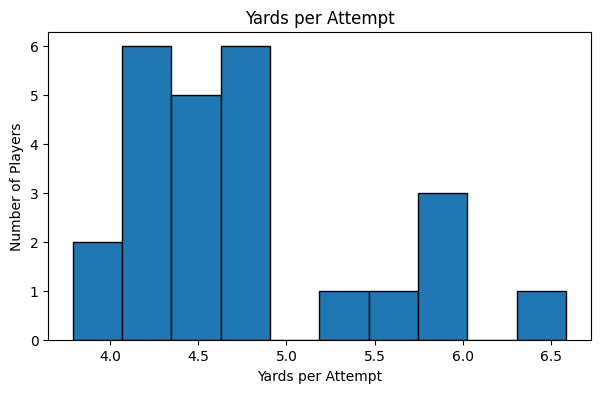

              Player  Rush Yds  Att  TD  20+  40+  Lng  Rush 1st  Rush 1st%  \
0     Saquon Barkley      2005  345  13   17    7   72        82       23.8   
1      Derrick Henry      1921  325  16   19    5   87        93       28.6   
2     Bijan Robinson      1456  304  14    5    0   37        82       27.0   
3    Jonathan Taylor      1431  303  11   11    4   70        71       23.4   
4       Jahmyr Gibbs      1412  250  16   13    3   70        70       28.0   
5        Josh Jacobs      1329  301  15    7    0   38        73       24.2   
6     Kyren Williams      1299  316  14    2    0   30        85       26.9   
7      Chuba Hubbard      1195  250  10    8    0   38        62       24.8   
8        Aaron Jones      1138  255   5    3    1   41        49       19.2   
9       Bucky Irving      1122  207   8    8    3   56        52       25.1   
10      James Conner      1094  236   8    6    2   53        66       28.0   
11       Rico Dowdle      1079  235   2    2    0   

In [18]:
display(Markdown("# Running Backs"))
display(Markdown("---"))

# Yards Per Attempt graph
display(Markdown("## How efficient are running backs on a per-carry basis?"))

rushing_2024["YdsPerAtt"] = rushing_2024["Rush Yds"] / rushing_2024["Att"]

plt.figure(figsize=(7, 4))
plt.hist(rushing_2024["YdsPerAtt"], bins=10, edgecolor="black")
plt.title("Yards per Attempt")
plt.xlabel("Yards per Attempt")
plt.ylabel("Number of Players")
plt.show()


print(rushing_2024)

In [8]:
receiving_2024 = import_table("receiving", "2024")
print(receiving_2024)

                Player  Rec   Yds  TD  20+  40+  LNG  Rec 1st  1st%  Rec FUM  \
0        Ja'Marr Chase  127  1708  17   19    8   70       75  59.1        0   
1     Justin Jefferson  103  1533  10   28    4   97       62  60.2        1   
2     Brian Thomas Jr.   87  1282  10   18    7   85       53  60.9        0   
3         Drake London  100  1271   9   12    0   39       67  67.0        0   
4    Amon-Ra St. Brown  115  1263  12   14    1   66       71  61.7        1   
5          Jerry Jeudy   90  1229   4   13    3   89       57  63.3        0   
6         Malik Nabers  109  1204   7   16    2   59       55  50.5        1   
7         Brock Bowers  112  1194   5   15    1   57       61  54.5        0   
8          CeeDee Lamb  101  1194   6   16    4   65       54  53.5        1   
9        Ladd McConkey   82  1149   7   15    4   60       52  63.4        2   
10        Trey McBride  111  1146   2   10    0   37       63  56.8        0   
11  Jaxon Smith-Njigba  100  1130   6   